In [ ]:
import osmnx as ox
import matplotlib.pyplot as plt
import numpy as np
import imageio
import os
import shutil

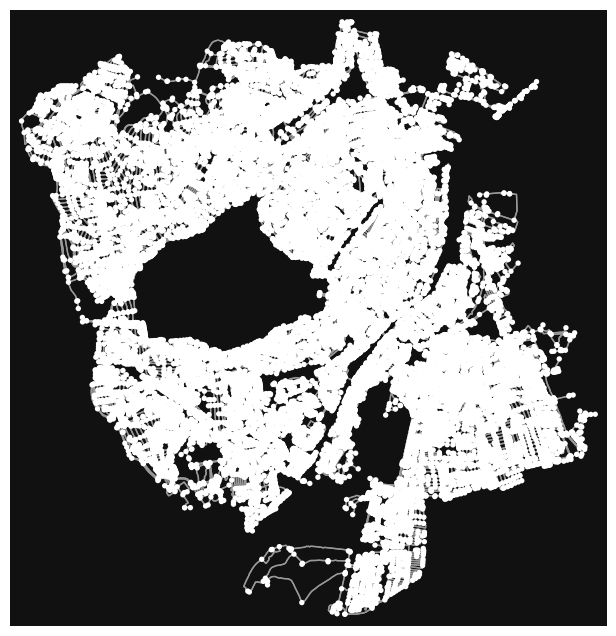

In [13]:
place_name = "Copenhagen Municipality, Denmark"
graph = ox.graph_from_place(place_name , network_type='walk')

fig, ax = ox.plot_graph(graph)
nodes, edges = ox.graph_to_gdfs(graph)

In [127]:
nodes, edges = ox.graph_to_gdfs(graph)
nodes = nodes.drop(['highway' , 'ref' , 'railway'], axis=1)
edges = edges.drop(['highway' , 'oneway' , 'reversed' , 'maxspeed'], axis=1)

In [ ]:
edges['u'] = edges.index.map(lambda x: x[0])
edges['v'] = edges.index.map(lambda x: x[1])


osmid              name     length  \
u      v          key                                            
118725 2512504197 0    1355182986  Banegårdspladsen  14.315994   
118738 4924695592 0     699713642               NaN  11.838357   
118744 1277939659 0     699713644               NaN  15.868216   
                  1     112439593               NaN  99.070859   
       1277939654 0     112439593               NaN  64.339114   

                                                                geometry  \
u      v          key                                                      
118725 2512504197 0    LINESTRING (12.56291 55.67398, 12.56297 55.673...   
118738 4924695592 0    LINESTRING (12.56184 55.66284, 12.56179 55.662...   
118744 1277939659 0    LINESTRING (12.56003 55.66172, 12.56019 55.66161)   
                  1    LINESTRING (12.56003 55.66172, 12.55952 55.661...   
       1277939654 0    LINESTRING (12.56003 55.66172, 12.56055 55.661...   

                             service bridge lanes  ref access width junction  \
u      v          key                                                          
118725 2512504197 0              NaN    NaN   NaN  NaN    NaN   NaN      NaN   
118738 4924695592 0              NaN    NaN   NaN  NaN    NaN   NaN      NaN   
118744 1277939659 0    parking_aisle    NaN   NaN  NaN    NaN   NaN      NaN   
                  1    parking_aisle    NaN   NaN  NaN    NaN   NaN      NaN   
       1277939654 0    parking_aisle    NaN   NaN  NaN    NaN   NaN      NaN   

                      tunnel       u           v  
u      v          key                             
118725 2512504197 0      NaN  118725  2512504197  
118738 4924695592 0      NaN  118738  4924695592  
118744 1277939659 0      NaN  118744  1277939659  
                  1      NaN  118744  1277939659  
       1277939654 0      NaN  118744  1277939654

<Axes: >

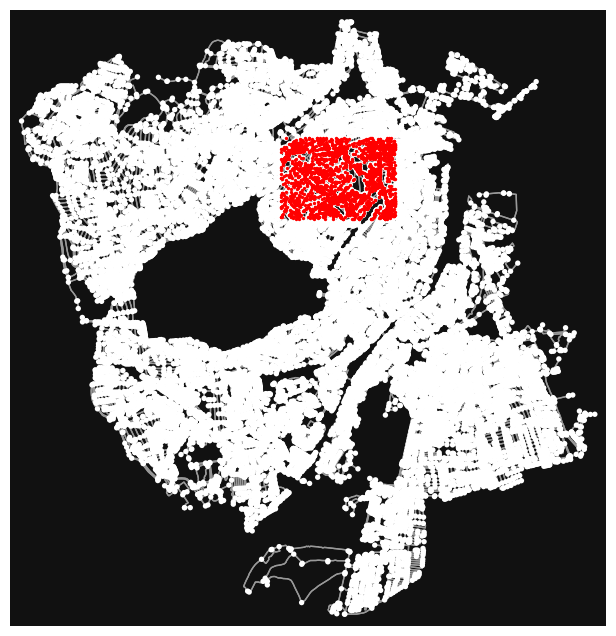

In [133]:
central_area = nodes[
    (nodes["x"] > 12.54300)
    & (nodes["x"] < 12.58291)
    & (nodes["y"] > 55.69268)
    & (nodes["y"] < 55.70864)
]

subgraph = graph.subgraph(central_area.index)

fig, ax = ox.plot_graph(graph, show=False, close=False)
central_area.plot(ax=ax, color="red", zorder=3 , markersize=2)

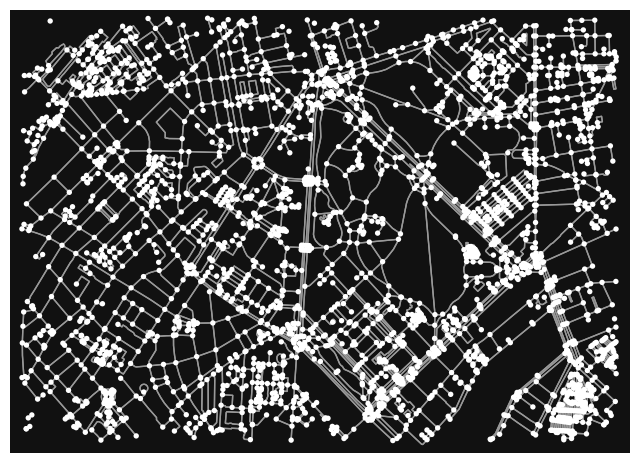

In [130]:
fig, ax = ox.plot_graph(subgraph, show=False, close=False) 

In [289]:
def next(point_before, Unique_ID, edges, arrival_point):
    possible_streets = edges[((edges.u == Unique_ID) | (edges.v == Unique_ID)) & ((edges.u != point_before) & (edges.v != point_before)) & 
                             (edges.u.isin(central_area.index) & edges.v.isin(central_area.index))]
    if len(possible_streets) == 0:
        possible_streets = edges[
            ((edges.u == Unique_ID) | (edges.v == Unique_ID)) & (
                edges.u.isin(central_area.index) & edges.v.isin(central_area.index)
            )
        ]

    x_best = central_area.loc[ arrival_point , "x"]
    y_best = central_area.loc[ arrival_point , "y"]
    xs = []
    ys = []
    for street in possible_streets.index : 
        u = edges.loc[street , "u"]
        v = edges.loc[street , "v"]
        arrive = v if u == Unique_ID else u
        if arrive == arrival_point:
            print("arrived")
            return arrive , street, edges.loc[street , "length"]
        elif arrive not in central_area.index:
            print("not in central area")
            xs.append(0)
            ys.append(0)
            continue
        arrive = central_area.loc[arrive]

        xs.append(arrive.x)
        ys.append(arrive.y)
    whight = 1/np.array(ox.distance.euclidean(xs ,ys  , x_best , y_best))
    whight = whight / whight.sum()
    street = np.random.choice(possible_streets.index , p = whight)
    u = edges.loc[street , "u"]
    v = edges.loc[street , "v"]
    next_node = v if u == Unique_ID else u
    return next_node , street, edges.loc[street , "length"]

In [302]:
arrival_point = central_area.index[-10]
def simulation(arrival_point , edges, N = 400):
    result = next(0 , central_area.index[0] , edges , arrival_point)
    line = [result[0]]
    streets = [result[1]]
    result = next(0, line[-1] , edges , arrival_point)
    line.append(result[0])

    streets.append(result[1])
    size = 0
    check = False
    for i in range(N) : 
        result = next(line[-2], line[-1] , edges , arrival_point)
        line.append(result[0])
        streets.append(result[1])
        size += result[2]
        if result[0] == arrival_point:
            print("arrived")
            check = True
            break

    if not check:
        print("not arrived")
        size*=10000
    
    return size ,line ,streets

sizes, lines, streets = [], [], []
for i in range(5):
    size, line, street = simulation(arrival_point, edges, N = 50)
    sizes.append(size)
    lines.append(line)
    streets.append(street)

sorted_indices = np.argsort(sizes)
sizes = [sizes[i] for i in sorted_indices]
lines = [lines[i] for i in sorted_indices]
streets = [streets[i] for i in sorted_indices]
print(sizes)

not arrived
not arrived
not arrived
not arrived
not arrived
[15951375.343922857, 17590892.84690589, 19920868.246440563, 24711397.243732523, 25504232.46591292]


In [303]:
os.makedirs("temp_images", exist_ok=True)

line = lines[0]
for i, node in enumerate(line):
    path = nodes.loc[line[:i+1]]
    fig, ax = ox.plot_graph(subgraph, show=False, close=False)
    path.plot(ax=ax, color="blue", zorder=3, linewidth=2, markersize=2)
    path.iloc[[0]].plot(ax=ax, color="yellow", zorder=4, markersize=50)
    path.iloc[[-1]].plot(ax=ax, color="red", zorder=4, markersize=50)
    central_area.iloc[[-10]].plot(ax=ax, color="green", zorder=4, markersize=50)

    for street in streets[0][:i+1]:
        edge = edges.loc[street]
        ax.plot(
            edge.geometry.xy[0],
            edge.geometry.xy[1],
            color="green",
            linewidth=1,
            alpha=0.7,
        )

    plt.savefig(f"temp_images/step_{i}.png")
    plt.close(fig)

images = []
for i in range(len(line)):
    images.append(imageio.imread(f"temp_images/step_{i}.png"))
imageio.mimsave("evolution.gif", images, duration=0.5)

shutil.rmtree("temp_images")

/tmp/ipykernel_26516/2457942569.py:27: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f"temp_images/step_{i}.png"))
